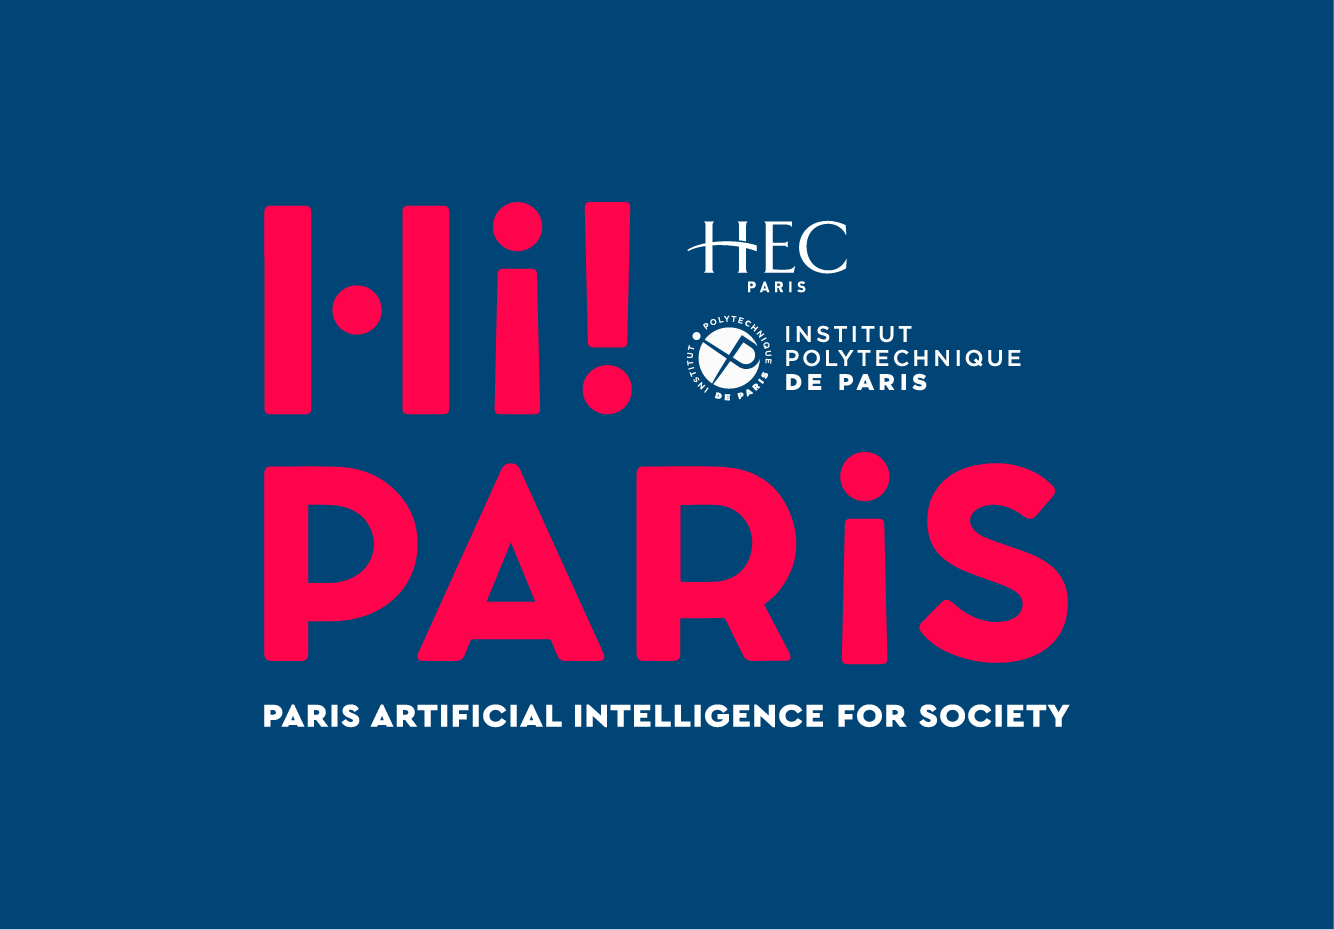

In [1]:
from IPython import display
display.Image("../src/figures/Hi!PARIS_logo_bleu.png")

<br>
<body>
    <p style="font-size:50px;text-align:center; color:#004475"><b><span style="color: #e61853">Hi!</span>ckathon 3</b></p><br>
    <p style="font-size:35px;text-align:center; color:#004475">Week 1 - Third Part :
    <p style="font-size:35px;text-align:center; color:#004475"> Feature engineering and algorithm setup</p><br>
    <p style="font-size:25px;text-align:center; color:#004475">Estimated duration : 1h</p><br>
    <br><p style="font-size:15px;text-align:left; color:#004475"><b>Authors : Haddam Yacine, Ka Alioune, Renaud Adrien, Vizy Jean Nicolas and Calot Baptiste </b></p><br>
</body>
<br>

PART 3 : Feature engineering and algorithm setup
======

In this lab, we briefly recall some machine learning basics, and we are interested in a problem of building a regression model using machine learning algorithms.

## What is a machine learning model:

The Building a machine learning model can be summed up in finding a link function $f$
 ($Y)=f(X) + \epsilon$) which is most often the
result of error minimization : <p style="text-align: center;">$\sum_i E(Y_i,f(X_i))$</p> where
$(X_i,Y_i)$ is a list of pairs (features, target).

**Objective:** 
- Train the model from a dataset and assess its ability to generalize on unseen data
- Understand the explanatory factors of our target
    
**Method:**
- Separate the target variable from the features
- separate the data into three samples (train / validation / test)
- train the model (on the train set) and evaluate its performance (on the test set).

## Instructions for this tutorial:
- Load the dataset from workspace.
- Train a linear model to predict the `meter_reading`, plot the coefficients of each of the features of the database. Evaluate with metrics on train and test.



We will use the [sklearn package](https://fr.wikipedia.org/wiki/Scikit-learn) for model and various metrics

### Data Path

`data_dir` is the path to data folder.

In [1]:
data_dir = "../data"

## Libraries

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import warnings
from IPython import display

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

sys.path.append('../src/notebooks')
from utils.get_data import load_data
from utils.utils_model import plot_importance, plot_max_depth_influence, plot_n_estimators_influence
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import r2_score


pd.set_option('display.max_columns', 500)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Load data

In [4]:
data = pd.read_feather(os.path.join(data_dir, "merged/data.feather"))

# remove building 1099 that has abnormal behaviour
data = data[data.building_id != 1099]

## Features of the Dataset

- Building metadata
   * `building_id`: unique identifier of the building.
   * `site_id`: unique identifier of the site.
   * `primaryspaceusage`: Primary space usage of all buildings is mapped using the [energystar scheme building description types](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/identify-your-property-type). 
   * `square_feet`: Floor area of building in square meters (m2).
   *  `lat`: Latitude of building location to site level.
   *  `lng`: Longitude of building location to site level.


- Weather data
   * <code>timestamp</code>: date and time in the format YYYY-MM-DD hh:mm:ss. Local timezone.
   * <code>site_id</code>: unique identifier of the site.
   * <code>air_temperature</code>: The temperature of the air in degrees Celsius (ºC).
   * <code>cloud_coverage</code>: Portion of the sky covered in clouds, in [oktas](https://en.wikipedia.org/wiki/Okta).
   * <code>dew_temperature</code>: The dew point (the temperature to which a given parcel of air must be cooled at constant pressure and water vapor content in order for saturation to occur) in degrees Celsius (ºC).
   * <code>precip_depth_1_hr</code>: The depth of liquid precipitation that is measured over a one hour accumulation period (mm).
   * <code>sea_lvl_pressure</code>: The air pressure relative to Mean Sea Level (MSL) (mbar or hPa).
   * <code>wind_direction</code>: The angle, measured in a clockwise direction, between true north and the direction from which the wind is blowing (degrees).
   * <code>wind_speed</code>: The rate of horizontal travel of air past a fixed point (m/s).


- Meter reading data
    *   `timestamp`: date and time in the format YYYY-MM-DD hh:mm:ss. 2016 and 2017 data.
    *   `building_id`: unique identifier of the building.
    *   `meter_reading`: meter reading in kilowatt hour (kWh) .
    *   `meter`: meter type, `chilledwater`, `electricity`, `hotwater` or `steam` .

```json
{0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}
```

It is always a good practice to explicitly state the features that we would like to use before training machine learning algorithms.

In [5]:
columns_to_use = [
    'site_id', 'building_id',
    'timestamp',
    'lat', 'lng',
    'primary_use',
    'square_feet',
    'air_temperature', 'dew_temperature', 'precip_depth_1_hr', 'wind_speed', 'sea_level_pressure', 'wind_direction',
    'meter_name',
    'meter_reading'
]
data = data[columns_to_use]

## Feature Engineering

Feature engineering is the process by which knowledge of data is used to construct explanatory variables, features, that can be used to train a predictive model. Engineering and selecting the correct features for a model will not only significantly improve its predictive power, but will also offer the flexibility to use less complex models that are faster to run and more easily understood.

Based on [EDA of meter readings]():

*   _Healthcare_,  and _Education_ usages shows the highest meter reading values while _Parking_ shows lower.
*   _Hotwater_ meter shows the highest meter reading values.
*   Monthly behaviour (meter-reading median) shows higher readings in warm season.
*   Hourly behaviour (meter-reading median) shows higher values from 6 to 19 hs.
*   Weekday behaviour: lowers during weekends.
* There is also a significant difference between sites

Based on these conclusions, we can create new features to in order to have an accurate model or to avoid complex one

### Feature Engineering from timestamps

The timestamp in itself is not a useful feature. But we can extract from it some powerful features like the hour of the day or the day of the week.

In [6]:
# hour
data["hour"] = data["timestamp"].dt.hour.astype("int8")
# days of the week (mon=0 and sun=6)
data["weekday"] = data["timestamp"].dt.dayofweek.astype("int8")
# month
data["month"] = data["timestamp"].dt.month.astype("int8")
# year
data["year"] = data["timestamp"].dt.year.astype("int16")
# days (1 to 31)
data["day"] = data["timestamp"].dt.day.astype("int8")

Do you think that there is some other features that could be interesting?

```python
# business hours
data['is_wider_busness_hours'] = np.where((data["hour"] >= 7) & (data["hour"] <=19 ), 1, 0)

# Weekend
data['is_weekend'] = np.where((data["weekday"] >= 0) & (data["weekday"] <= 4), 0, 1)

# Season of year
data['season'] = (np.where(data["month"].isin([12, 1, 2]), 0,
                   np.where(data["month"].isin([3, 4, 5]), 2,         
                   np.where(data["month"].isin([6, 7, 8]), 3,          
                   np.where(data["month"].isin([9, 10, 11]), 1, 0)))))
```

### Feature Engineering from geographic position

We have seen a difference between US and European sites. Lets create a feature for this.

In [7]:
data["zone_geo"] = "US"
data.loc[data.lng > -4, 'zone_geo'] = "EUROPE"

### Feature Engineering  from transformation 

Feature transformations can include aggregating, combining transforming attributes to create new features. Useful and relevant features will depend on the problem at hand but averages, sums, log or ratios can better expose trends to a model.

We can also transform a numerical feature into a categorical feature by cutting it into classes. This can be interesting to avoid the impact of outliers or to reduce the variance of the output variable.

##### Example: 

```python
# log transformation
data['square_feet_log'] = data['square_feet'].apply(np.log)

# polynomial transformation
data['air_temperature_squared'] = data['air_temperature']**2
```

## Encoding your data

Some algorithms can't work with categorical data directly. This means that categorical data must be converted to a numerical form. 
To Convert Categorical Data to Numerical Data, this involves two steps :

- Integer  (ordinal or cardinal)
- One-Hot Encoding

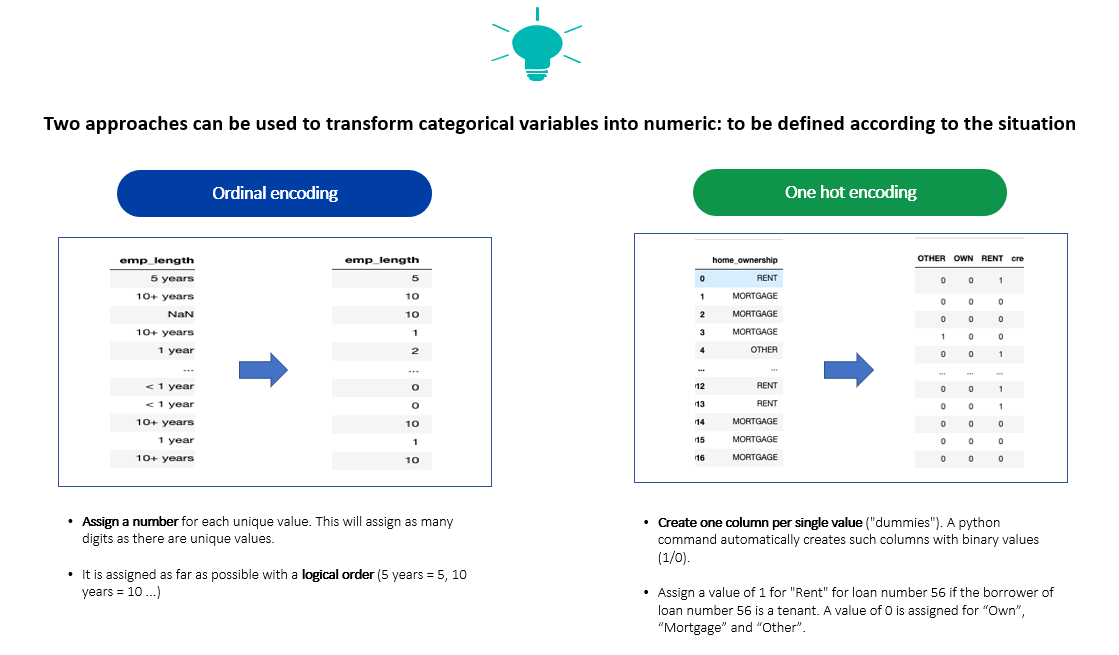

In [2]:
display.Image("../src/figures/encoding.png")

The problem with the encoding is that it associates a value to each modality and that the values 0 and 1 are closer than the values 0 and 2. It turns out that the algorithm trained on the data will understand this notion of distance. 
Sometimes it doesn't make sense to encode the modalities. For example with the modalities of Primary use, there is no different distance between the modalities education, office, services, parking. On the contrary, if we want to encode a modality such as "small", "medium", "large", then it makes sense to put "small" at 0, "medium" at 1 and "large" at 2
because "small" is closer to "medium" than to "large"

Use [pd.get_dummies()](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) for OneHotEncoding

In [8]:
# list of columns to encode using One-Hot-Encoding
columns_to_encode = ["meter_name", "primary_use", "zone_geo", "site_id"]

# encode those columns
encoded_data = pd.get_dummies(data[columns_to_encode], columns=columns_to_encode)

# add encoded columns to the data
data = pd.concat([data, encoded_data], axis=1)

<br>
<body style="text-align:center">
    <p style="color:#004475;"><span class="info">&#x1F6C8;</span>
       You can also use scikitlearn library for OneHotEncoding :<a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html">LINK</a>.</p>
</body>
<br>

In [9]:
data.head()

,site_id,building_id,timestamp,lat,lng,primary_use,square_feet,air_temperature,dew_temperature,precip_depth_1_hr,wind_speed,sea_level_pressure,wind_direction,meter_name,meter_reading,hour,weekday,month,year,day,zone_geo,meter_name_chilledwater,meter_name_electricity,meter_name_hotwater,meter_name_steam,primary_use_Education,primary_use_Entertainment/public assembly,primary_use_Healthcare,primary_use_Industry,primary_use_Lodging/residential,primary_use_Office,primary_use_Other,primary_use_Parking,primary_use_Public services,primary_use_Services,zone_geo_EUROPE,zone_geo_US,site_id_0,site_id_1,site_id_2,site_id_3,site_id_4,site_id_5,site_id_6,site_id_7,site_id_9,site_id_11,site_id_12,site_id_13,site_id_15
0,0,0,2017-09-27 10:00:00,28.52,-81.400002,Education,7432.0,24.4,23.9,0.0,2.1,1012.0,60.0,electricity,301.009094,10,2,9,2017,27,US,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,3,2017-09-27 10:00:00,28.52,-81.400002,Education,23685.0,24.4,23.9,0.0,2.1,1012.0,60.0,electricity,310.564911,10,2,9,2017,27,US,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,9,2017-09-27 10:00:00,28.52,-81.400002,Office,27000.0,24.4,23.9,0.0,2.1,1012.0,60.0,electricity,158.490494,10,2,9,2017,27,US,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,14,2017-09-27 10:00:00,28.52,-81.400002,Education,86250.0,24.4,23.9,0.0,2.1,1012.0,60.0,chilledwater,6500.395020,10,2,9,2017,27,US,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,18,2017-09-27 10:00:00,28.52,-81.400002,Education,111891.0,24.4,23.9,0.0,2.1,1012.0,60.0,electricity,1989.116943,10,2,9,2017,27,US,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0


## Train / Validation / Test Split 

The **train-validation-test** split is a technique for training and evaluating the performance of a machine learning algorithm.

The **procedure** involves taking a dataset and dividing it into three subsets:
- The **train** subset is used to fit the model and is referred to as the training dataset. You should not evaluate the performance of the model on this train set,
- The **validation** subset is used to tune hyperparameters of an algorithm. For example the *max_depth* for a regression tree,
- The **test** subset is not used to train the model; it is only used at the end to evaluate the performances of the model. For a purist, once you 'opened' the test set, you should not modify the model anymore.


**Strategy**
   - Define a test set, and separate the remaining between train and validation.
   - Generally they represent respectively 70% | 15% | 15% of the initial dataset.

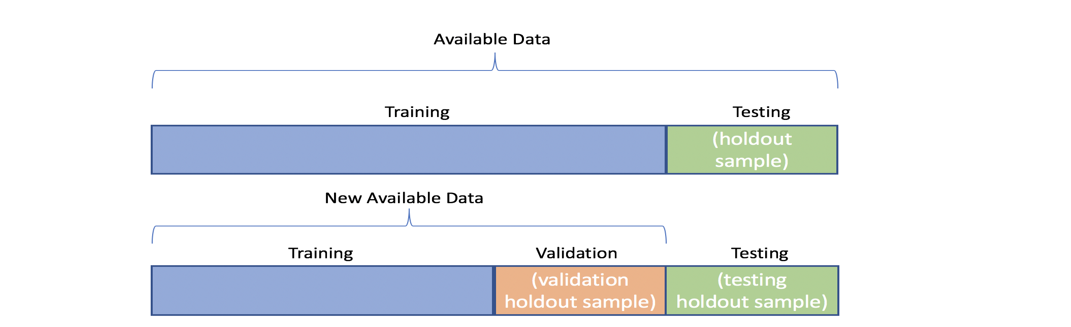

In [3]:
display.Image("../src/figures/train_test_1.png")

In [10]:
train = data[data["timestamp"].between("2016-01-01 00:00:00", "2016-12-31 23:00:00")].reset_index(drop=True)
val = data[data["timestamp"].between("2017-01-01 00:00:00", "2017-09-01 00:00:00")].reset_index(drop=True)
test = data[data["timestamp"] > "2017-09-01 00:00:00"].reset_index(drop=True)

In [11]:
print(f"Number of examples in the train set: {train.shape[0]}")
print(f"Number of examples in the val set:   {val.shape[0]}")
print(f"Number of examples in the test set:  {test.shape[0]}")

Number of examples in the train set: 1520987
Number of examples in the val set:   1064033
Number of examples in the test set:  533214


</h3><font color='red'>  ! Be sure that all buildings in the test and validation sets are also in train set !</font></h3>

In [12]:
# List of unique buildings in tain set
train_building = train.building_id.unique().tolist()

# Keep only buildings that are in train set
train = train[train.building_id.isin(train_building)].reset_index(drop=True)
test = test[test.building_id.isin(train_building)].reset_index(drop=True)
val = val[val.building_id.isin(train_building)].reset_index(drop=True)

## Splitting your data (Features / Target)

It is a rather practical approach because generally the algorithms of machine learning ask for the features on the one hand and the target on the other hand.

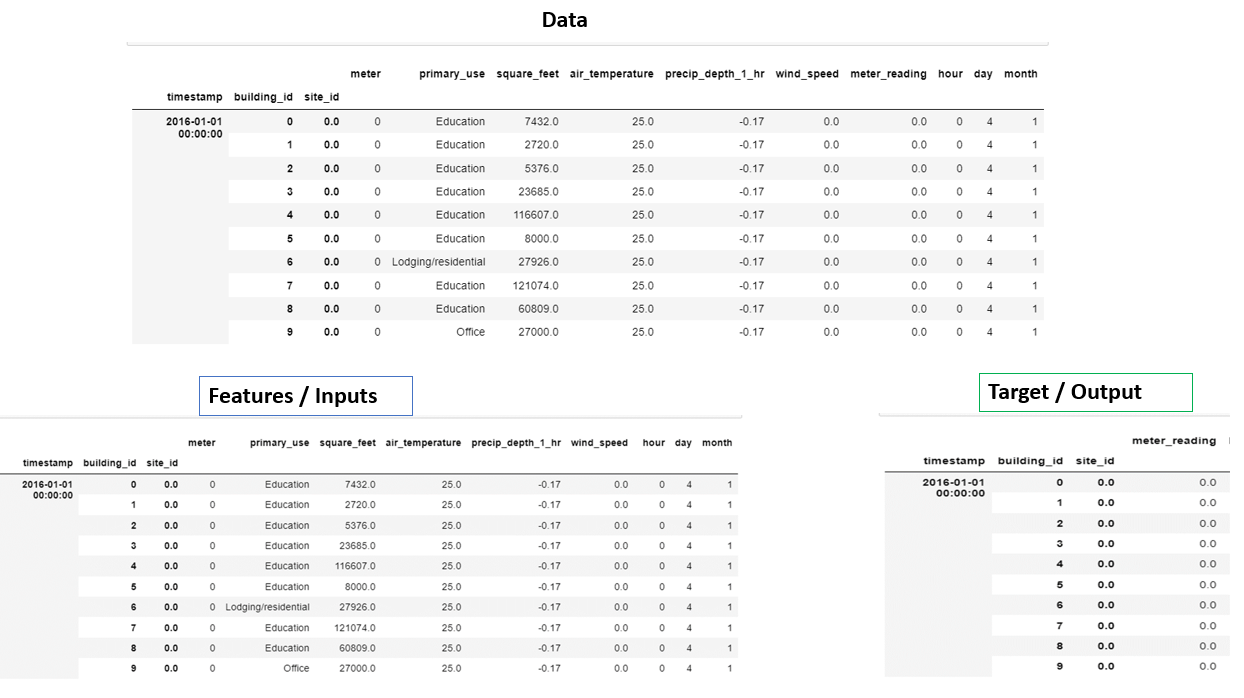

In [5]:
display.Image("../src/figures/split_columns.png")

In [13]:
features = [
    # 'building_id',
    'lat',
    'lng',
    'square_feet',
    'air_temperature',
    'dew_temperature',
    'precip_depth_1_hr',
    'wind_speed',
    'sea_level_pressure',
    'wind_direction',
    'hour',
    'weekday',
    'month',
    'meter_name_chilledwater',
    'meter_name_electricity',
    'meter_name_hotwater',
    'meter_name_steam',
    'primary_use_Education',
    'primary_use_Entertainment/public assembly',
    'primary_use_Healthcare',
    'primary_use_Industry',
    'primary_use_Lodging/residential',
    'primary_use_Office',
    'primary_use_Other',
    'primary_use_Parking',
    'primary_use_Public services',
    'primary_use_Services',
    'zone_geo_EUROPE',
    'zone_geo_US',
    'site_id_0',
    'site_id_1',
    'site_id_2',
    'site_id_3',
    'site_id_4',
    'site_id_5',
    'site_id_6',
    'site_id_7',
    'site_id_9',
    'site_id_11',
    'site_id_12',
    'site_id_13',
    'site_id_15',
]

target = "meter_reading"

In [14]:
print(f"::: Number of features {len(features)}")

::: Number of features 41


In [15]:
train_features = train[features]
val_features = val[features]
test_features = test[features]

In [16]:
train_target = train[target]
val_target = val[target]
test_target = test[target]

In [17]:
train

,site_id,building_id,timestamp,lat,lng,primary_use,square_feet,air_temperature,dew_temperature,precip_depth_1_hr,wind_speed,sea_level_pressure,wind_direction,meter_name,meter_reading,hour,weekday,month,year,day,zone_geo,meter_name_chilledwater,meter_name_electricity,meter_name_hotwater,meter_name_steam,primary_use_Education,primary_use_Entertainment/public assembly,primary_use_Healthcare,primary_use_Industry,primary_use_Lodging/residential,primary_use_Office,primary_use_Other,primary_use_Parking,primary_use_Public services,primary_use_Services,zone_geo_EUROPE,zone_geo_US,site_id_0,site_id_1,site_id_2,site_id_3,site_id_4,site_id_5,site_id_6,site_id_7,site_id_9,site_id_11,site_id_12,site_id_13,site_id_15
0,0,0,2016-06-28 12:00:00,28.520000,-81.400002,Education,7432.0,25.6,22.200001,0.000000,0.0,1016.5,0.0,electricity,247.768997,12,1,6,2016,28,US,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,11,2016-06-28 12:00:00,28.520000,-81.400002,Education,49073.0,25.6,22.200001,0.000000,0.0,1016.5,0.0,electricity,532.396973,12,1,6,2016,28,US,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,40,2016-06-28 12:00:00,28.520000,-81.400002,Entertainment/public assembly,26944.0,25.6,22.200001,0.000000,0.0,1016.5,0.0,electricity,335.136993,12,1,6,2016,28,US,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,46,2016-06-28 12:00:00,28.520000,-81.400002,Services,9045.0,25.6,22.200001,0.000000,0.0,1016.5,0.0,electricity,16.146000,12,1,6,2016,28,US,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,70,2016-06-28 12:00:00,28.520000,-81.400002,Parking,387638.0,25.6,22.200001,0.000000,0.0,1016.5,0.0,electricity,34.127998,12,1,6,2016,28,US,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1520982,15,1400,2016-02-14 19:00:00,42.470001,-76.500000,Lodging/residential,21168.0,-15.6,-21.700001,-1.000000,2.6,1034.0,310.0,chilledwater,3.019400,19,6,2,2016,14,US,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1520983,15,1400,2016-03-16 03:00:00,42.470001,-76.500000,Lodging/residential,21168.0,8.3,8.300000,-1.000000,4.1,1012.0,290.0,chilledwater,3.777300,3,2,3,2016,16,US,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1520984,15,1400,2016-02-29 12:00:00,42.470001,-76.500000,Lodging/residential,21168.0,8.9,4.400000,-1.000000,5.7,997.5,200.0,chilledwater,3.869300,12,0,2,2016,29,US,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1520985,15,1400,2016-03-10 08:00:00,42.470001,-76.500000,Lodging/residential,21168.0,12.8,10.000000,-1.000000,0.0,1016.0,0.0,chilledwater,5.057300,8,3,3,2016,10,US,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


## Scaling of Data

Depending on the task at hand, it can be useful to scale each feature by subtracting the mean and dividing it by its standard deviation.
In practice we often use scikit-learn's standard scaler objects. Note that the test set is scaled with the means and standard deviations calculated on the columns of the training set

<br>
<body style="text-align:center">
    <p style="color:#004475;"><span class="info">&#x1F6C8;</span>
       You can use scikitlearn library for scaling your data :<a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html">LINK</a>.</p>
</body>
<br>

<br>
<body style="text-align:center">
    <p style="color:#004475;"><span class="info">&#x1F6C8;</span>
       There are also variants to scale the data :<a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html?highlight=min+max+scaler#sklearn.preprocessing.MinMaxScaler">LINK</a>.</p>
</body>
<br>

Data scaling is mainly used to speed up model fitting or improving the performance of some model families such as neural networks or support vector machines.

Other models are not sensitive to scaling like random forests.

In addition to this, scaling data allows to compare the coefficients of a linear model trained on the data and to determine which variables are the most important for the prediction, based on the absolute value of their coefficient.

In [18]:
from sklearn.preprocessing import StandardScaler
scal = StandardScaler()
# We fit on the train
scal.fit(train_features) 
train_features = pd.DataFrame(scal.transform(train_features), columns= train_features.columns)
# We apply the transformation on the validation and test set
val_features = pd.DataFrame(scal.transform(val_features), columns = val_features.columns)
test_features = pd.DataFrame(scal.transform(test_features), columns = test_features.columns)

In [19]:
# save datasets for later use

SAVED_DATA_MODEL = True

PATH_MODEL_DATA = os.path.join(data_dir, "model")
if not(os.path.exists(PATH_MODEL_DATA)):
    os.mkdir(PATH_MODEL_DATA)

if SAVED_DATA_MODEL:
    train_features.to_feather(os.path.join(PATH_MODEL_DATA, 'train.feather'))
    val_features.to_feather(os.path.join(PATH_MODEL_DATA, 'val.feather'))
    test_features.to_feather(os.path.join(PATH_MODEL_DATA, 'test.feather'))

### Go Further :
[COMPREHENSIVE DATA EXPLORATION WITH PYTHON](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)


## Evaluation Metrics for a Regression Problem

 In this lab, as we are interested in a regression problem, we will first see some classic regression metrics.

Suppose we evaluate these metrics for a set $(y_i, \hat{y}_i)_{i=1,...n_{\text{test}}}$, where $y_i$ is the true value and   $\hat{y_i}$ is the prediction.


- **mean absolute error**:   
$\text{MAE} = \frac{1}{n_{\text{test}}} \sum_{i=1,...n_{\text{test}}} |y_i - \hat{y_i}|$ .

- **mean squared error**:   
$\text{MSE} = \frac{1}{n_{\text{test}}} \sum_{i=1,...n_{\text{test}}} (y_i - \hat{y_i})^2$. The most used.

- **max error**: 
$\text{MAX_Error} =  \max_{i=1,...n_{\text{test}}} (y_i - \hat{y_i})$. Calculates the maximum residual error. It is very sensitive to outliers

MSE has the benefit of penalizing large errors more so can be more appropriate in some cases, for example, if being off by 10 is more than twice as bad as being off by 5.

From an interpretation standpoint, MAE is clearly the winner. MSE does not describe average error alone and has other implications that are more difficult to tease out and understand.


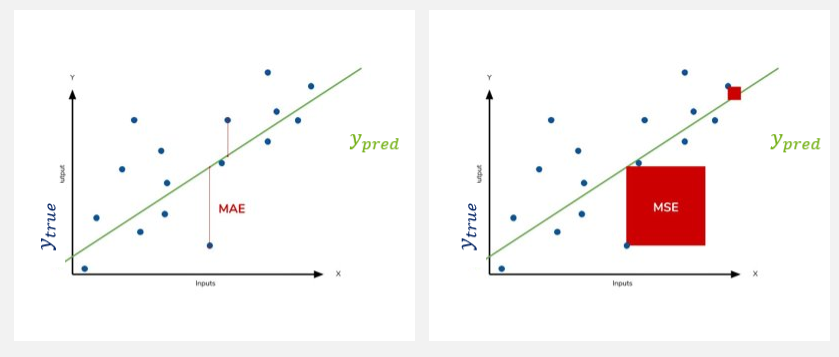

In [6]:
display.Image("../src/figures/metric.PNG")

## Fit a Linear Model on our data

In [20]:
reg = linear_model.LinearRegression()
reg = reg.fit(train_features, train_target)

## Feature importances

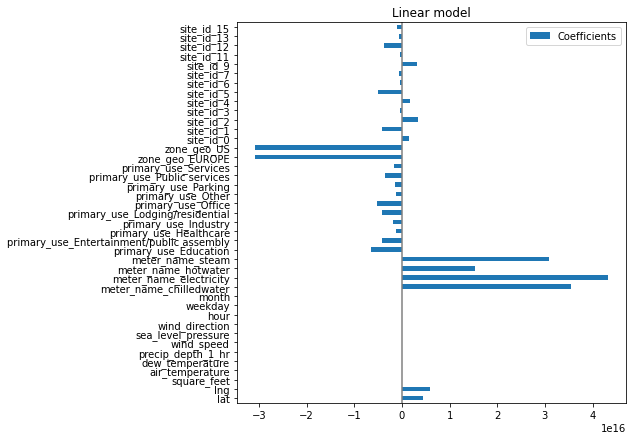

In [21]:
import matplotlib.pyplot as plt

coefs = pd.DataFrame(
   reg.coef_,
   columns=['Coefficients'], index=train_features.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Linear model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

## Evaluation of predictions


In [22]:
from sklearn.metrics import (
    mean_squared_error,
    max_error,
    mean_absolute_error,
    mean_squared_log_error,
)


def print_errors(model, X, y):
    y_pred = model.predict(X)

    print(f'MAE : {mean_absolute_error(y, y_pred):.0f}')
    print(f'MSE : {mean_squared_error(y, y_pred):.0f}')
    print(f'MAX : {max_error(y, y_pred):.0f}')

In [23]:
print_errors(reg, test_features, test_target)

MAE : 745
MSE : 33494052
MAX : 381648


We will see in the next course how to improve these performances with much more efficient models

## To Do

<font color='blue'> <h2> Feature Engineering </h2> </font>

1. Based of the feature importance of the Linear Model, drop some insignificant features on *train* and fit a new model. Is your model better now ?

In [ ]:
# To Do 

In [ ]:
selected_features = ['meter_name_chilledwater', 'meter_name_electricity', 'meter_name_hotwater', 'meter_name_steam', 
                     'primary_use_Education', 'zone_geo_EUROPE', 'zone_geo_US', 'site_id_9',
                    'site_id_4', 'site_id_3', 'site_id_2', 'site_id_9']

reg = linear_model.LinearRegression()

train_features_selected = train_features[selected_features]
test_features_selected = test_features[selected_features]
reg.fit(train_features_selected, train_target)

print_errors(reg, test_features_selected, test_target)

## Go further!
- Hastie T., Tibshirani R., Friedman J., « [The elements of Statistical Learning](http://statweb.stanford.edu/~tibs/ElemStatLearn/) - Data Mining, Inference and Prediction », pringer, 2009.

<br>
<body style="text-align:center">
    <p style="color:#004475;"><span class="info">&#x1F6C8;</span>
        You will be able to participate in a Q&A session of this course/exercise, which will take place on November 23 at 7:00 pm. The Zoom link for the session will be communicated soon. </p>
</body>
<br>

<p style="text-align:center;color:#004475;font-size:20px"><b>*** End ***</b></p>